In [1]:
import sys
sys.path.append('../')

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from SVI_solver_library.transform.AdapterTransform import AdapterTransform as Adapter
from SVI_solver_library.solver.ProjSolver import ProjSolver as ProjSolver

# Constants

# Sup functions


In [3]:
def get_ssm_from_v(u):
    slice1 = NSV * NSV
    slice2 = slice1 + NSV * NI
    slice3 = slice2 + NSV * NO
    A = u[:slice1].reshape(NSV, NSV)
    B = u[slice1:slice2].reshape(NSV, NI)
    C = u[slice2:slice3].reshape(NO, NSV)
    m = SSM(A, B, C)
    return m

In [4]:
def experement(F_ex, P_ex, sp, u_ex, loss_func, Y, U, X0, project):
    F_1 = Adapter(F_ex)
    P_1 = Adapter(P_ex)
    Ex_solver = ProjSolver(F_1, sp, P = P_1)
    answer, verbose = Ex_solver.solve(u_ex)
    plt.figure(figsize=(16, 6)) 
    plt.subplot(1, 3, 1)
    u0_history = verbose[:, 0]
    u1_history = verbose[:, 1]
    u2_history = verbose[:, 2]
    u3_history = verbose[:, 3]
    plt.plot(u0_history.numpy(), label='u0')  
    plt.plot(u1_history.numpy(), label='u1')  
    plt.plot(u2_history.numpy(), label='u2') 
    plt.plot(u3_history.numpy(), label='u3')
    plt.title('Изменение переменных от времени')
    plt.xlabel('Ось X')
    plt.ylabel('Ось Y')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 3, 2)
    plt.plot(verbose.numpy())
    plt.title('Изменение переменных от времени: все')
    plt.xlabel('Ось X')
    plt.ylabel('Ось Y')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 3, 3)
    mr = get_ssm_from_v(project(answer))
    with torch.no_grad():
        p, _ = mr(U, X0)
        plt.plot(p.numpy(), label='PREDICT')
        plt.plot(Y.numpy(), label='REAL')
        plt.legend()
        plt.grid(True)
        plt.show()
        print('ERR:', loss_func(p, Y))

# SSMs

In [5]:
class SSM(torch.nn.Module):

    def __init__(self, ni, no, nsv):
        super().__init__()
        self.ni = ni
        self.no = no
        self.nsv = nsv
        self.A = torch.nn.Linear(nsv, nsv)
        self.B = torch.nn.Linear(ni, nsv)
        self.C = torch.nn.Linear(nsv, no)
        # self.A = torch.randn([nsv, nsv])
        # self.B = torch.randn([ni, nsv])
        # self.C = torch.randn([nsv, no])
    

    def forward(self, u, x0 = None):
        """
            - u: BATCH x LEN_OF_TS x NUM_OF_INPUTS
            - x: BATCH x NUM_OF_STATE_VARS
        """
        if type(x0) is None:
            x = torch.zeros((u.shape[0], self.nsv))
        else:
            x = x0
        ut = torch.transpose(u, 0, 1)
        y = torch.zeros([ut.shape[0], ut.shape[1], self.no])
        x_hist = torch.zeros([u.shape[1], u.shape[0], self.nsv])
        for (i, u_i) in enumerate(ut):
            y[i] += self.C(x)
            x = self.A(x) +self.B(u_i)
            x_hist[i] += x
        return torch.transpose(y, 0, 1), torch.transpose(x_hist, 0, 1)


In [6]:
class SSM(torch.nn.Module):

    def __init__(self, ni, no, nsv):
        super().__init__()
        self.ni = ni
        self.no = no
        self.nsv = nsv
        self.A = torch.randn([nsv, nsv], requires_grad=True)
        self.B = torch.randn([nsv, ni], requires_grad=True)
        self.C = torch.randn([no, nsv], requires_grad=True)
    

    def forward(self, u, x0 = None):
        """
            - u: LEN_OF_TS x NUM_OF_INPUTS
            - x: NUM_OF_STATE_VARS
        """
        if type(x0) is None:
            x = torch.zeros((self.nsv))
        else:
            x = x0
        y = torch.zeros([u.shape[0], self.no])
        x_hist = torch.zeros([u.shape[0], self.nsv])
        for (i, u_i) in enumerate(u):
            y[i] += self.C @ x
            x = self.A @ x +self.B @ u_i
            x_hist[i] += x
        return y, x_hist


In [7]:
class SSM(torch.nn.Module):
    

    def __init__(self, A, B, C):
        super().__init__()

        wA = A
        wB = B
        wC = C
        self.ni = wB.shape[1]
        self.no = wC.shape[0]
        self.nsv = wA.shape[0]
        self.A = torch.nn.Parameter(A)
        self.B = torch.nn.Parameter(B)
        self.C = torch.nn.Parameter(C)
    

    @staticmethod
    def auto_init(ni, no, nsv):
        A = torch.randn([nsv, nsv], requires_grad=True)
        B = torch.randn([nsv, ni], requires_grad=True)
        C = torch.randn([no, nsv], requires_grad=True)
        return SSM(A, B, C)
        

    def forward(self, u, x0 = None):
        """
            - u: LEN_OF_TS x NUM_OF_INPUTS
            - x: NUM_OF_STATE_VARS
        """
        if type(x0) is None:
            x = torch.zeros((self.nsv))
        else:
            x = x0
        y = torch.zeros([u.shape[0], self.no])
        x_hist = torch.zeros([u.shape[0], self.nsv])
        for (i, u_i) in enumerate(u):
            y[i] += self.C @ x
            x = self.A @ x +self.B @ u_i
            x_hist[i] += x
        return y, x_hist


# Gen data

In [8]:
NSV = 5
NI = 3
NO = 2
TS_LENGTH = 10
GS = max([NSV, NI, NO])


In [9]:
X0 = torch.zeros([NSV])

In [10]:
U = torch.tensor([[
    i > 5, (i > 5) and (i < 10), (i > 5) and (i < 10) and (i > 15) 
] for i in range(TS_LENGTH)], dtype=torch.float32)

In [11]:
M = SSM.auto_init(nsv=NSV, ni=NI, no=NO)
with torch.no_grad():
    Y, _ = M(U, X0)
    Y = (Y - Y.min()) / (Y.max() - Y.min())
    Y = Y - Y[0]
LOSS = torch.nn.MSELoss(reduction='sum')


tensor(81.0789, grad_fn=<MseLossBackward0>)
tensor(0.8327, grad_fn=<MseLossBackward0>)
tensor(0.0177, grad_fn=<MseLossBackward0>)
tensor(2.1717e-05, grad_fn=<MseLossBackward0>)
tensor(8.5469e-09, grad_fn=<MseLossBackward0>)
tensor(2.4063e-11, grad_fn=<MseLossBackward0>)
tensor(6.6089e-12, grad_fn=<MseLossBackward0>)
tensor(1.3429e-12, grad_fn=<MseLossBackward0>)
tensor(2.0695e-13, grad_fn=<MseLossBackward0>)
tensor(1.1102e-13, grad_fn=<MseLossBackward0>)
tensor(3.5527e-14, grad_fn=<MseLossBackward0>)
tensor(1.8874e-12, grad_fn=<MseLossBackward0>)
tensor(1.1448e-10, grad_fn=<MseLossBackward0>)
tensor(3.7517e-06, grad_fn=<MseLossBackward0>)
tensor(7.4545e-12, grad_fn=<MseLossBackward0>)
tensor(9.3836e-10, grad_fn=<MseLossBackward0>)


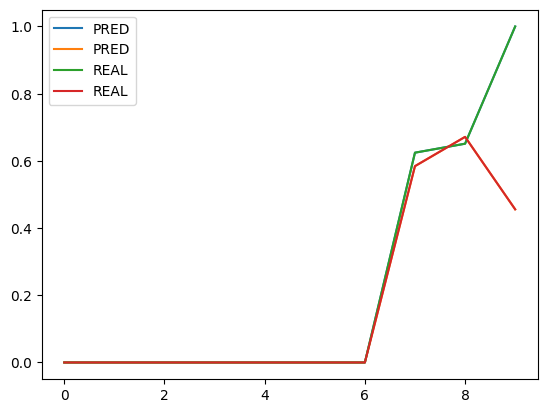

In [12]:
m = SSM.auto_init(nsv=NSV, ni=NI, no=NO)
opt = torch.optim.Adam(m.parameters(),)
for i in range(15000):
    p, _ = m(U, X0)
    l = LOSS(p, Y)
    l.backward()
    if i % 1000 == 0:
        print(l)
    opt.step()
    opt.zero_grad()
p, _ = m(U, X0)
l = LOSS(p, Y)
plt.plot(p.detach().numpy(), label='PRED')
plt.plot(Y.detach().numpy(), label='REAL')
plt.legend()
print(l)

# Experements

In [13]:
def pad_grad(g):
    return torch.nn.functional.pad(g.squeeze(0), [0, abs(g.shape[1] - GS), 0, abs(g.shape[0] - GS)], )


def F_ex_grad(u):
    m = get_ssm_from_v(u)
    p, _ = m(U, X0)
    l = LOSS(p, Y)
    l.backward()
    gAp = m.A.grad
    gBp = m.B.grad
    gCp = m.C.grad
    return np.concat([gAp.reshape(-1), gBp.reshape(-1), gCp.reshape(-1)])


def F_ex_mse(u):
    m = get_ssm_from_v(u)
    p, _ = m(U, X0)
    l = LOSS(p, Y)
    return l.detach()


def project(x):
    norm = np.linalg.norm(x)
    if norm > 1:
        return x / norm
    return x


def P_ex1(u):
    return project(u)

    

/tmp/ipykernel_32366/1874935908.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


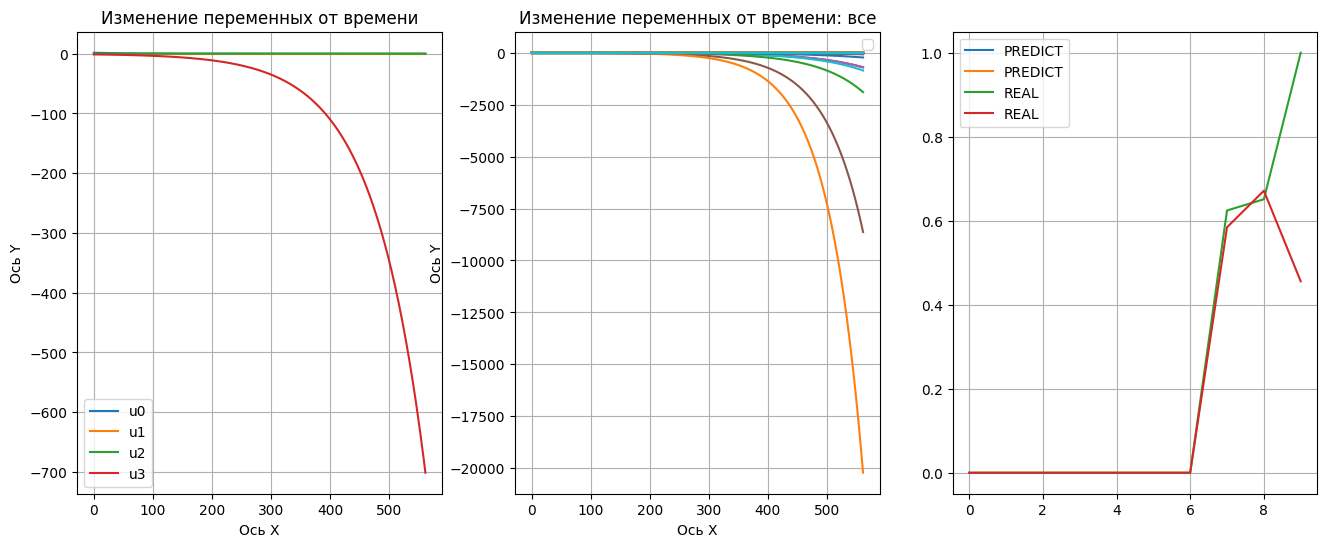

ERR: tensor(nan)


In [14]:
u_ex = torch.concatenate([m.A.reshape(-1), m.B.reshape(-1), m.C.reshape(-1)]).detach()
sp = torch.concatenate([m.A.reshape(-1), m.B.reshape(-1), m.C.reshape(-1)]).detach()
experement(F_ex_grad, P_ex1, sp, u_ex, LOSS, Y, U, X0, project)

/tmp/ipykernel_32366/1874935908.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


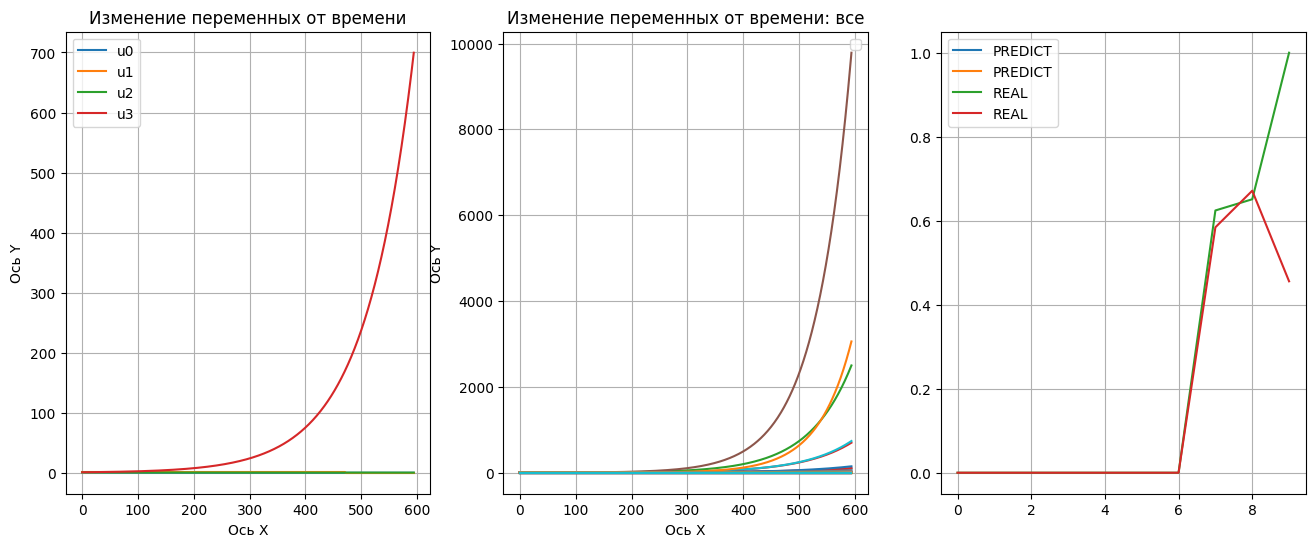

ERR: tensor(nan)


In [15]:
u_ex = torch.rand([NSV * NSV + NSV * NI + NSV * NO])
sp = torch.concatenate([m.A.reshape(-1), m.B.reshape(-1), m.C.reshape(-1)]).detach()
experement(F_ex_grad, P_ex1, sp, u_ex, LOSS, Y, U, X0, project)

/tmp/ipykernel_32366/1874935908.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


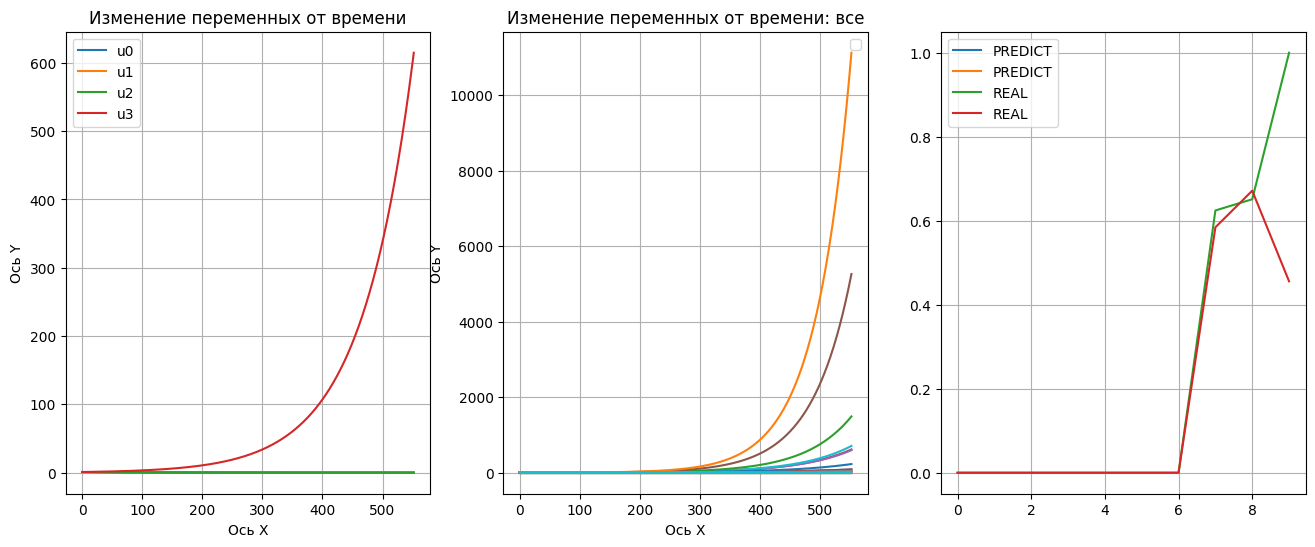

ERR: tensor(nan)


In [16]:
u_ex = torch.ones([NSV * NSV + NSV * NI + NSV * NO]) * 1
sp = torch.concatenate([m.A.reshape(-1), m.B.reshape(-1), m.C.reshape(-1)]).detach()
experement(F_ex_grad, P_ex1, sp, u_ex, LOSS, Y, U, X0, project)

/tmp/ipykernel_32366/1874935908.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


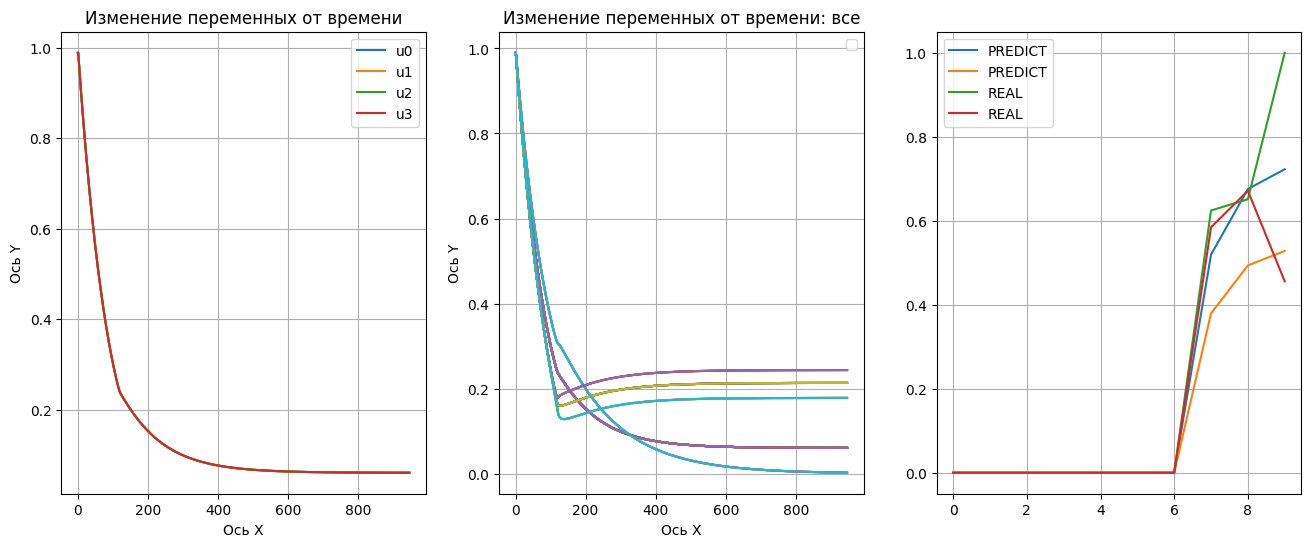

ERR: tensor(0.1676)


In [17]:
u_ex = torch.ones([NSV * NSV + NSV * NI + NSV * NO]) * 1
sp = torch.ones([NSV * NSV + NSV * NI + NSV * NO]) * 1
experement(F_ex_grad, P_ex1, sp, u_ex, LOSS, Y, U, X0, project)

/tmp/ipykernel_32366/1874935908.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


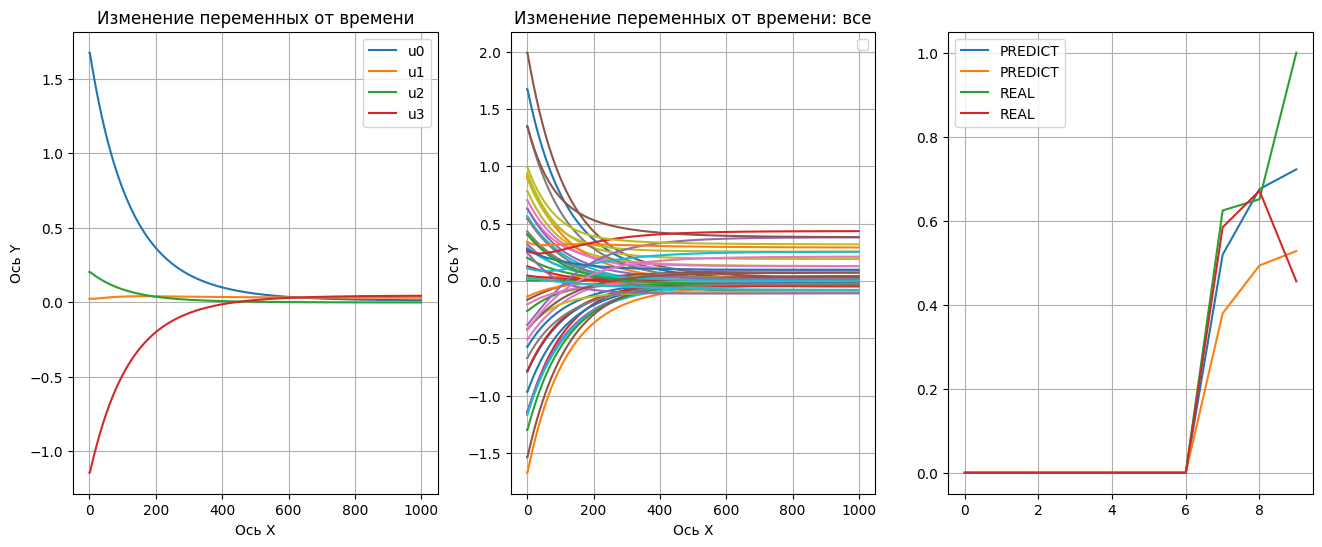

ERR: tensor(0.1676)


In [18]:
sp = torch.ones([NSV * NSV + NSV * NI + NSV * NO]) * 1
u_ex = torch.concatenate([m.A.reshape(-1), m.B.reshape(-1), m.C.reshape(-1)]).detach()
experement(F_ex_grad, P_ex1, sp, u_ex, LOSS, Y, U, X0, project)

/tmp/ipykernel_32366/1874935908.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


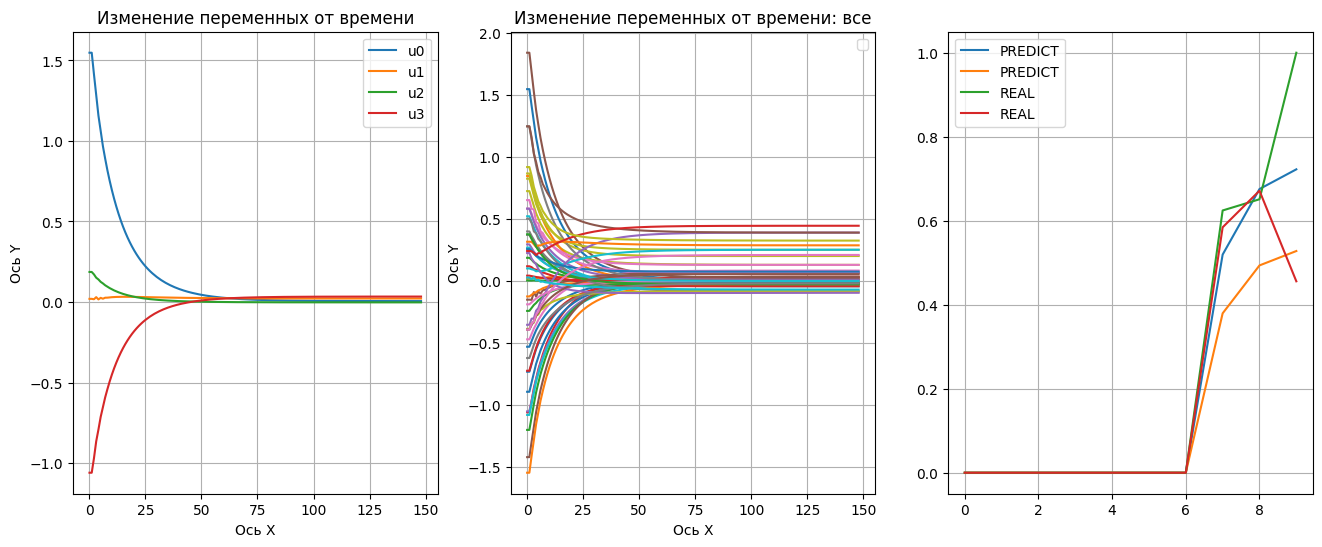

ERR: tensor(0.1675)


In [19]:
sp = torch.ones([NSV * NSV + NSV * NI + NSV * NO]) * 10
u_ex = torch.concatenate([m.A.reshape(-1), m.B.reshape(-1), m.C.reshape(-1)]).detach()
experement(F_ex_grad, P_ex1, sp, u_ex, LOSS, Y, U, X0, project)

/tmp/ipykernel_32366/1874935908.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


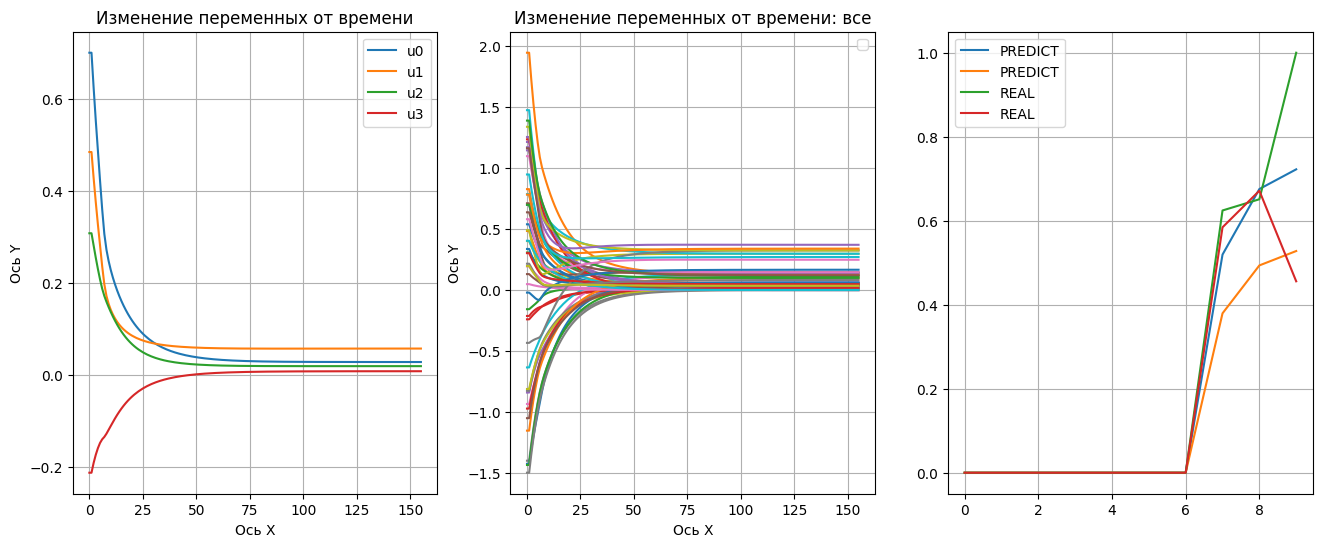

ERR: tensor(0.1675)


In [20]:
sp = torch.ones([NSV * NSV + NSV * NI + NSV * NO]) * 10
u_ex = torch.randn([NSV * NSV + NSV * NI + NSV * NO])
experement(F_ex_grad, P_ex1, sp, u_ex, LOSS, Y, U, X0, project)

/tmp/ipykernel_32366/1874935908.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


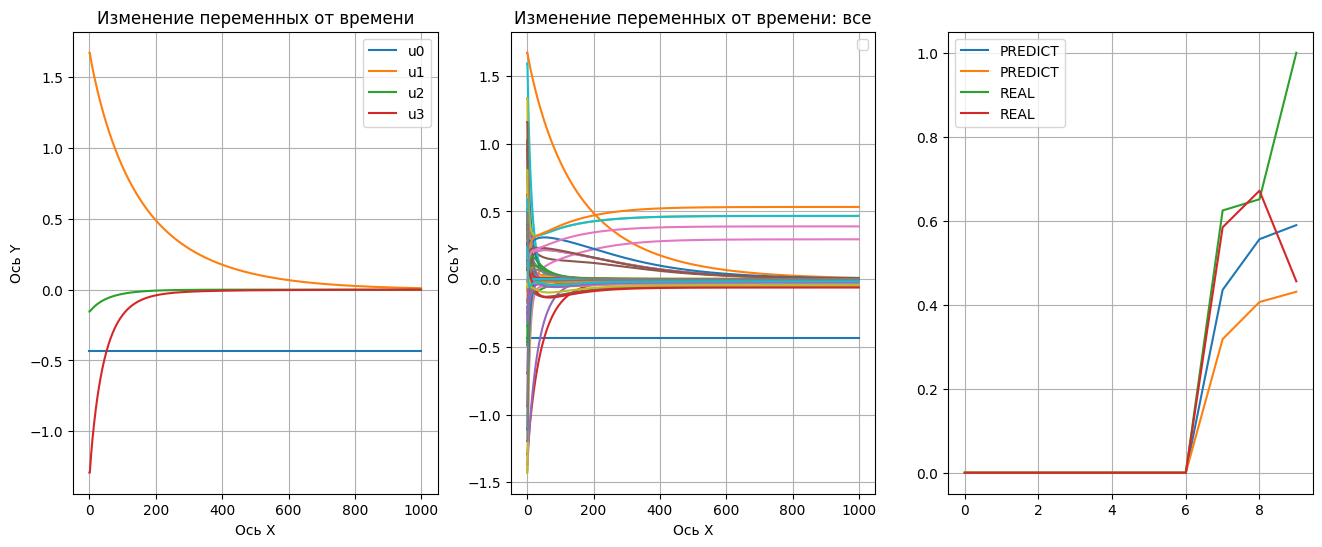

ERR: tensor(0.3549)


In [21]:
sp = torch.tensor(np.arange(NSV * NSV + NSV * NI + NSV * NO)).float()
u_ex = torch.randn([NSV * NSV + NSV * NI + NSV * NO])
experement(F_ex_grad, P_ex1, sp, u_ex, LOSS, Y, U, X0, project)